In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Waterloo/_MSCI_641/project'

/content/drive/MyDrive/Waterloo/_MSCI_641/project


In [15]:
import json, os
import numpy as np
import pandas as pd
from collections import defaultdict
import gc
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
datasets = dict()
dataset_names = ['train','val','test']

for dataset_name in dataset_names:
    datasets[dataset_name] = pd.read_json(path_or_buf=dataset_name + '.jsonl', lines=True)
    if 'id' not in datasets[dataset_name].columns:
        datasets[dataset_name]['id'] = datasets[dataset_name].index

features = ['postText', 'postPlatform', 'targetParagraphs', 'targetTitle',
       'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl']
features = ['postText', 'postPlatform', 'targetParagraphs', 'targetTitle',
       'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl']
features_text = ['postText','targetParagraphs', 'targetTitle', 'targetDescription',
                'targetKeywords']
features_url = ['targetUrl', 'targetMedia' ]

target1 = 'tags'
target2 = 'spoiler'

In [5]:
def return_longest_spoiler_index(spoilers):
    max_len = 0
    for i,spoiler in enumerate(spoilers):
        if len(spoiler) > max_len:
            max_len = len(spoiler)
            longest_spoiler = i
    return longest_spoiler

In [6]:
def findPosTags(x):
    tokPos = []
    for pos in x['spoilerPositions']:
        st,en = pos
        idx = 0
        for i,p in enumerate([x['targetTitle']] + x['targetParagraphs']):
            if i==st[0]+1:
                start_ind = idx + st[1]
                end_ind = idx + en[1]

                tokPos.append([start_ind,end_ind])
                break
            if i==0:
                idx+=len(p)+3
            else:
                idx+=len(p)+1

    return tokPos

In [7]:


label_encoder = {"phrase": 0,"passage": 1,"multi":2}
label_decoder = {0:"phrase",1:"passage", 2:"multi"}

for dataset_name in dataset_names:

    print(dataset_name)

    temp_data = datasets[dataset_name]

    if dataset_name != 'test':
        temp_data = temp_data[temp_data['spoilerPositions'].apply(lambda x: len(x[0])) > 1]
        temp_data['tokPos'] = temp_data.apply(findPosTags,1)

        temp_data['tags'] = temp_data['tags'].apply(lambda x: x[0])
        temp_data['label'] = temp_data['tags'].map(label_encoder)
        temp_data['tokenPosition'] = temp_data.apply(findPosTags,1)
        temp_data['longest_spoiler_index'] = temp_data['spoiler'].apply(return_longest_spoiler_index)
        temp_data['longest_spoiler'] = temp_data.apply(lambda x: x['spoiler'][x['longest_spoiler_index']],1)
        temp_data['longest_tokPos'] = temp_data.apply(lambda x: x['tokPos'][x['longest_spoiler_index']],1)

    temp_data['postText'] = temp_data['postText'].apply(lambda x: x[0])

    for col in ['targetParagraphs', 'targetMedia']:

        print(col)

        temp_data[col + '_listlen'] = temp_data[col].apply(lambda x: len(x) if x is not None else 0)
        temp_data[col + '_concat'] = temp_data[col].apply(lambda x: ' '.join(x) if x is not None else '')

    for col in ['postText', 'targetTitle', 'targetDescription', 'targetKeywords', 'targetParagraphs_concat']:

        print(col)
        temp_data[col + '_len'] = temp_data[col].apply(lambda x: len(x.split()) if x is not None else 0)

    temp_data['title_para'] = temp_data['targetTitle'] + " - " + temp_data['targetParagraphs_concat']

    datasets[dataset_name] = temp_data

train


C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['tokPos'] = temp_data.apply(findPosTags,1)
C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['tags'] = temp_data['tags'].apply(lambda x: x[0])
C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

targetParagraphs
targetMedia
postText
targetTitle
targetDescription
targetKeywords
targetParagraphs_concat


C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data[col + '_listlen'] = temp_data[col].apply(lambda x: len(x) if x is not None else 0)
C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data[col + '_concat'] = temp_data[col].apply(lambda x: ' '.join(x) if x is not None else '')
C:\Users\sachi\AppData\Local\Temp\ipykernel_16328\652402177.py:33: SettingWithCopyWarning: 
A v

val
targetParagraphs
targetMedia
postText
targetTitle
targetDescription
targetKeywords
targetParagraphs_concat
test
targetParagraphs
targetMedia
postText
targetTitle
targetDescription
targetKeywords
targetParagraphs_concat


In [8]:
def convert2squadFormat_old(df):
    df_fin = df[['id','targetTitle','postText',"title_para","tokPos","spoiler"]]
    df_fin["asnwers"] = df_fin.apply(lambda x: {'text':x['spoiler'], "answer_start":[x['tokPos'][0][0]]},1)
    df_fin['id'] = df_fin['id'].astype(str)
    df_fin = df_fin.drop(columns=["tokPos","spoiler"])
    df_fin.columns = ['id',"title","question","context","answers"]
    return df_fin

In [9]:
datasets['test'].iloc[8]

postId                                                                    53e76y
postText                       The First Person In The Royal Family Has Just ...
postPlatform                                                              reddit
targetParagraphs               [The Queen’s cousin has become the first membe...
targetTitle                    The first person in the royal family has just ...
targetDescription              The Queen’s cousin has become the first member...
targetKeywords                                                              None
targetMedia                    [http://cdn.pinknews.co.uk/images/2016/08/truv...
targetUrl                      http://www.pinknews.co.uk/2016/09/18/the-first...
id                                                                             8
targetParagraphs_listlen                                                      18
targetParagraphs_concat        The Queen’s cousin has become the first member...
targetMedia_listlen         

In [10]:
datasets['train'].shape

(3199, 31)

<AxesSubplot:xlabel='label', ylabel='Count'>

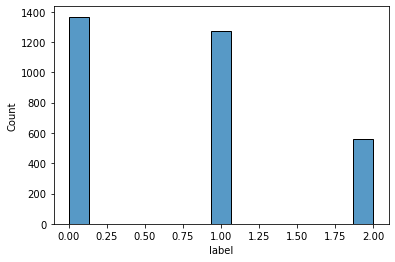

In [20]:
sns.histplot(datasets['train']['label'])

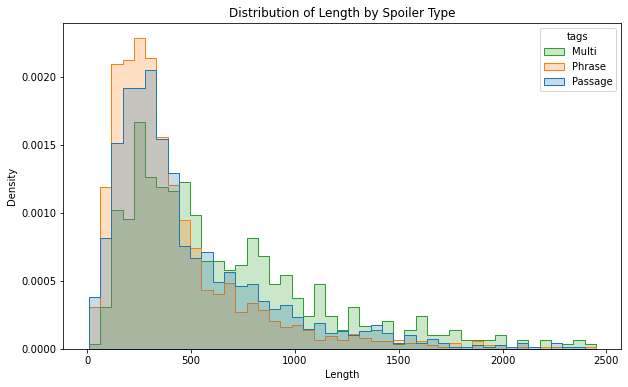

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=datasets['train'][datasets['train']['targetParagraphs_concat_len']<2500], x='targetParagraphs_concat_len', hue='tags', element='step', stat='density', common_norm=False)
plt.title('Distribution of Length by Spoiler Type')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend(title='tags',  labels=['Multi', 'Phrase', 'Passage'])
plt.show()